# BoltzRank #
## Luca Negrini - Mat. 956516 ##
### From "BoltzRank: Learning to Maximize Expected Ranking Gain" ###
#### Maxims M. Volkovs, Richard S. Zemel ####

------
#### Initialization ####

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

%load_ext cython

# install lightgbm (required only on first run)
# import sys
# !{sys.executable} -m pip install lightgbm

import os
import os.path
import numpy as np
import lightgbm
import matplotlib.pyplot as plt

# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from sklearn.datasets import load_svmlight_file 

# datasets available at: 
# https://www.microsoft.com/en-us/research/project/mslr/
DATASET_FOLDER = "C:/opt/kiis-training/MSLR-WEB10K/Fold1/"
PERM_FOLDER = DATASET_FOLDER + "perms/"
METRIC_NAME = 'Custom-MSE'

-----
#### Data loading ####

In [3]:
def ensureFile(path):
    if not os.path.exists(path) or not os.path.isfile(path):
        raise FileNotFoundError("'" + path + "': no such file")        
    return path

def retrieveFileNames():
    folder = DATASET_FOLDER + '/' if DATASET_FOLDER[-1:] != '/' else DATASET_FOLDER
    train_file = ensureFile(folder + "train.txt")
    valid_file = ensureFile(folder + "vali.txt")
    test_file = ensureFile(folder + "test.txt")
    return train_file, valid_file, test_file

def loadDataset(path):
    return load_svmlight_file(path, query_id=True)

def loadLightGBM(svmlight_dataset):
    query_lens = [sum(1 for _ in group) for key, group in itertools.groupby(svmlight_dataset[2])]
    return lightgbm.Dataset(data=svmlight_dataset[0], label=svmlight_dataset[1], group=query_lens)

In [4]:
class Query:
    def __init__(self, qid):
        self.qid = qid
        self.labels_to_docs = {}
        self.perms = np.empty((1,1))
        self.probs = np.empty((1,1))
    def addlabel(self, label):
        if not label in self.labels_to_docs:
            self.labels_to_docs[label] = list()
    def adddoc(self, label, doc):
        self.labels_to_docs[label].append(doc)
    def finalize(self):
        self.labels = np.zeros(len(self.labels_to_docs.keys()), dtype=int)
        self.docs = np.empty(len(self.labels_to_docs.keys()), dtype=object)
        i = 0
        totaldocs = 0
        sorteddict = sorted(self.labels_to_docs.items(), reverse = True)
        for label, docs in sorteddict:
            self.labels[i] = label
            self.docs[i] = np.zeros(len(docs), dtype=int)
            for j in range(len(docs)):
                self.docs[i][j] = docs[j]
            i += 1
            totaldocs += len(docs)
        self.alldocs = np.concatenate(self.docs)
        self.flatlabels = np.zeros(totaldocs, dtype=np.double)
        i = 0
        for label, docs in sorteddict:
            for j in range(len(docs)):
                self.flatlabels[i] = label
                i += 1
        del self.labels_to_docs
    def setperms(self, perms):
        self.perms = perms
    def setprobs(self, probs):
        self.probs = probs
    def __repr__(self):  
        return str(self)
    def __str__(self):
        res = "Query " + str(self.qid) + "["
        for i in range(len(self.labels)):
            res += "\n" + str(self.labels[i]) + " -> " + str(self.docs[i])
        res += "]"
        for i in range(len(self.perms)):
            res += "\n[" + str(self.perms[i]) + "] -> p: " + str(self.probs[i]) + ", g: " + str(self.gains[i])
        return res

In [5]:
# parameters:
#  dataset: svmlight_dataset 
#      the datset to process
# returned values:
#  query_to_labels_to_documents: dict(int -> dict(float -> list(int)))
#      a map containing, for each query in the dataset, the documents (row index in the dataset) provided 
#      in the input dataset grouped by label
#  doc_to_query: dict(document -> query)
#      a mapping between document (row index in the dataset) and the relative query
def mapQueryToDocuments(dataset):
    queries = {}
    doc_to_query = {} 
    alllabels = np.negative(np.ones(len(dataset[2]), dtype=np.double))
    for i in range(0, len(dataset[2])):
        if not dataset[2][i] in queries:
            queries[dataset[2][i]] = Query(dataset[2][i])
        query = queries[dataset[2][i]]
        query.addlabel(dataset[1][i])
        query.adddoc(dataset[1][i], i)
        doc_to_query[i] = query.qid
        alllabels[i] = dataset[1][i]
        
    for q in queries.values():
        q.finalize()
    
    return queries, alllabels, doc_to_query

-----
#### BoltzRank logic in Cython ####

In [19]:
%%cython

from cython.parallel import prange
from cython import boundscheck, wraparound

# The sign-preserving function introduced in formula (4) and defined in formula (5). The implementation follows 
# the one proposed near the end of Section 4.2.
#
# parameters:
#  x: double 
#      the difference in rankings between the two current documents
#  m: int
#      the number of documents available for the current query
# returned values:
#  val: double
#      the result of the function
@boundscheck(False)
@wraparound(False)
cdef double g_q(double x, int m) nogil:
    return (2 * x) / (m - 1)

# The energy function E(R|S) defined in formula (4). This represents the incompatibility between the 
# given ranking and the given score. More energy means less compatibility
#
# parameters:
#  rank: int[:]
#      the array of document IDs (row index in the dataset) representing the ranking
#  scores: double[:]
#      the array of document scores, score of document i will be retrieved from scores[i]
# returned values:
#  val: double
#      the energy of the ranking w.r.t. the target scores. The lower, the better.
@boundscheck(False)
@wraparound(False)
cdef double energy(int[:] rank, double[:] scores) nogil:
    cdef int m = len(rank)
    if m == 1 or m == 0:
        return 0
    cdef double factor = 2 / (m * (m - 1))
    cdef double res = 0
    cdef int j
    cdef int k
    for k in prange(m, schedule='static', num_threads=8):
        for j in range(k + 1, m):
            res += g_q(j - k, m) * (scores[rank[j]] - scores[rank[k]])
    return factor * res

from libc.math cimport exp

# The approximate rank probability P[Rq](R|S) defined in formula (12). This approximates the probability of a ranking
# given a scoring. Since the effective computation is intractable due to the exponentail number of possible rankings, 
# this is computed through a montecarlo estimate over sample ranking sets
#
# parameters:
#  sampleSet: int[:,:]
#      the array containing all sample rankings, expresed as arrays of document IDs (row index in the dataset)
#  rank: int[:]
#      the ranking whose probability is to be computed, expressed as array of document IDs (row index in the dataset)
#  scores: double[:]
#      the scores to be used for the energy computation, score of document i will be retrieved from scores[i]
# returned values:
#  val: double
#      the probability of the given ranking
@boundscheck(False)
@wraparound(False)
cpdef double[:] approx_rank_probabilities(int[:,:] sampleSet, double[:] norm_probs, double[:] scores) nogil:
    cdef double norm = 0
    cdef int r
    for r in prange(len(sampleSet), schedule='static', num_threads=8):
        norm_probs[r] = exp(-energy(sampleSet[r], scores))
        norm += norm_probs[r]
    for r in prange(len(norm_probs), schedule='static', num_threads=8):
        norm_probs[r] = norm_probs[r] / norm
    return norm_probs

from math import factorial
import numpy as np

#int[:,:] source, int i, int j, int count, int[:,:] perms
#return: number of not computed permutations
@boundscheck(False)
@wraparound(False)
def perform_permutation(query, int i, int j, int count, int[:,:] perms, int start):
    if not i in query.labels or not j in query.labels:
        # no swapping possible
        return count, start
    # find the indexes of the desired labels
    i = [k for k in range(len(query.labels)) if query.labels[k] == i][0]
    j = [k for k in range(len(query.labels)) if query.labels[k] == j][0]
    # find maximum amount of permutations that can be done
    cdef int _min = min(len(query.docs[i]), len(query.docs[j]))
    cdef int amount = min(count, _min)
    # randomly selects the indexes
    cdef int[:] first = np.random.choice(len(query.docs[i]), amount)
    cdef int[:] second = np.random.choice(len(query.docs[j]), amount)
    # perform the single-element permutations
    cdef int k
    cdef perm
    cdef int[:] p
    for k in range(amount):
        perm = query.docs.copy()
        perm[i][first[k]], perm[j][second[k]] = query.docs[j][second[k]], query.docs[i][first[k]]
        p = np.concatenate(perm)
        perms[start + k] = p
    return count - amount, start + amount

import random

@boundscheck(False)
@wraparound(False)
cdef bint contained(int[:,:] container, int[:] array) nogil:
    cdef bint match
    cdef int i
    cdef int j
    for i in prange(len(container), schedule='static', num_threads=8):
        if container[i][0] == -1 or len(container[i]) != len(array):
            continue
        else:
            match = True
            for j in range(len(container[i])):
                if container[i][j] != array[j]:
                    match = False
                    break
            if match:
                return True
    return False

cdef void setrow(int[:,:] container, int pos, int[:] array) nogil:
    cdef int i
    for i in prange(len(container[pos]), schedule='static', num_threads=8):
        container[pos][i] = array[i]
                

#source: label -> docid*, i: int, j: int, count: int, perms_with_prob: tuple<int> -> float
#return: number of not computed permutations
@boundscheck(False)
@wraparound(False)
def perform_permutation2(query, int i, int j, int count, int[:,:] perms, int start):
    if not i in query.labels or not j in query.labels:
        # no swapping possible
        return count, start
    # find the indexes of the desired labels
    i = [k for k in range(len(query.labels)) if query.labels[k] == i][0]
    j = [k for k in range(len(query.labels)) if query.labels[k] == j][0]
    cdef int c = 0
    cdef int _min = min(len(query.docs[i]), len(query.docs[j]))
    cdef int amount = max(1, int(_min * .5))
    limit = factorial(_min) / (factorial(amount) * factorial(_min - amount))
    cdef int k
    cdef int d
    for k in range(count):
        perm = query.docs.copy()
        first = random.sample(range(len(query.docs[i])), k=amount)
        second = random.sample(range(len(query.docs[j])), k=amount)
        for d in range(len(first)):
            perm[i][first[d]], perm[j][second[d]] = query.docs[j][second[d]], query.docs[i][first[d]]
        p = np.concatenate(perm)
        if not contained(perms, p):
            setrow(perms, start + c, p)
            c += 1
            if c == limit:
                return count - c, start + c
        else:
            k -= 1
    return 0, start + c
    
import itertools

@boundscheck(False)
@wraparound(False)
cdef int[:,:] allPerms(int[:] source, long long fact):
    cdef int i = 0
    cdef int k
    perm = itertools.permutations(source)
    cdef int[:,:] result = np.zeros((fact, len(source)), dtype=int)
    for p in perm:
        for k in range(len(p)):
            result[i][k] = p[k]
        i += 1
    return result

RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS = 100
RANK_SAMPLE_SET_DISTRIBUTIONS = [
                                int(.20 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->0
                                int(.18 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->1
                                int(.14 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->2
                                int(.08 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->3
                                int(.14 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->0
                                int(.12 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->1
                                int(.06 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->2
                                int(.04 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->0
                                int(.02 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->1
                                int(.02 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS)  # 1->0
                                ]

#cdef int[:,:] process_query(int query, double[:] labels, int[:,:] docs, double[:] probs) nogil:
@boundscheck(False)
@wraparound(False)
def process_query(query, alllables):
    cdef int carry = 0
    fact = factorial(len(query.alldocs))
    #s = " (" + str(RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS) + " permutations computed)"
    cdef perms
    cdef int last = 0
    if fact <= RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS:
        # evaluate all possible permutations, each one representing a different ranking
        perms = allPerms(query.alldocs, fact)
        #s = " (all " + str(fact) + " permutations computed)"
    else:
        perms = np.negative(np.ones((RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS, len(query.alldocs)), dtype=int))
        # switch the labels of the documents, then sort the documents by label to obtain a ranking
        carry, last = perform_permutation2(query, 4, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[0], perms, last)
        carry, last = perform_permutation2(query, 4, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[1] + carry, perms, last)
        carry, last = perform_permutation2(query, 4, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[2] + carry, perms, last)
        carry, last = perform_permutation2(query, 4, 3, RANK_SAMPLE_SET_DISTRIBUTIONS[3] + carry, perms, last)
        carry, last = perform_permutation2(query, 3, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[4] + carry, perms, last)
        carry, last = perform_permutation2(query, 3, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[5] + carry, perms, last)
        carry, last = perform_permutation2(query, 3, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[6] + carry, perms, last)
        carry, last = perform_permutation2(query, 2, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[7] + carry, perms, last)
        carry, last = perform_permutation2(query, 2, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[8] + carry, perms, last)
        carry, last = perform_permutation2(query, 1, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[9] + carry, perms, last)
        if carry != 0:
            if not query.alldocs in perms:
                perms[last] = query.alldocs
                #s = " (missing " + str(carry - 1) + " permutations - considering also dataset ranking)"
            #else:
                #s = " (missing " + str(carry) + " permutations) "
        perms = perms[perms.max(axis=1)>=0]
    cdef double[:] probs = np.zeros(len(perms))
    query.setperms(perms)
    query.setprobs(approx_rank_probabilities(perms, probs, alllables))
    #print("query " + str(query.qid) + " done " + s)
    return query

from libc.math cimport log, log2

@boundscheck(False)
@wraparound(False)
cdef double cross_entropy(double[:] probs, double[:] scores_probs) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(len(probs), schedule='static', num_threads=8):
        result += probs[i] * log(scores_probs[i])
    return -result

@boundscheck(False)
@wraparound(False)
cdef double dcg_k(int[:] rank, double[:] scores, int k) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(0, k, schedule='static', num_threads=8):
        result += (2**scores[rank[i]]) / (log2(i + 2)) # should be i+1, but with numbering starting from 1 instead of 0
    return result

@boundscheck(False)
@wraparound(False)
cdef double ndcg_k(int[:] true_rank, double[:] labels, int[:] rank, double[:] scores, int k) nogil:
    return dcg_k(rank, scores, k) / dcg_k(true_rank, labels, k)

@boundscheck(False)
@wraparound(False)
cdef double monte_carlo_gain(int[:] true_rank, double[:] labels, int[:,:] perms, double[:] scores_probs, double[:] scores) nogil:
    cdef double result = 0
    cdef int i
    cdef int k = min(10, len(true_rank))
    for i in prange(len(perms), schedule='static', num_threads=8):
        result += scores_probs[i] * ndcg_k(true_rank, labels, perms[i], scores, k)
    return result

@boundscheck(False)
@wraparound(False)
def eval_grads(queries, doc_to_query, preds, train_data): 
    cdef double lam = .9
    labels = train_data.get_label().astype(np.double)
    query_to_gain = {}
    cdef double[:] score_probs
    for q in queries.values():
        score_probs = np.zeros(len(q.probs), dtype=np.double)
        score_probs = approx_rank_probabilities(q.perms, score_probs, preds)
        query_to_gain[q.qid] = lam * monte_carlo_gain(q.alldocs, labels, q.perms, score_probs, preds) 
        query_to_gain[q.qid] -= (1 - lam) * cross_entropy(q.probs, score_probs)
    
    cdef double[:] gain = np.zeros_like(preds)
    cdef int i
    for i in range(len(gain)):
        gain[i] = query_to_gain[doc_to_query[i]]

    cdef double[:] hess = np.ones_like(gain) 
    return gain, hess   

In [7]:
train_file, valid_file, test_file = retrieveFileNames()

print("training file: " + train_file)
print("validation file: " + valid_file)
print("test file: " + test_file)
    
print("loading datasets... ")
import time
start = time.process_time()
train_dataset = loadDataset(train_file)
print("train dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
valid_dataset = loadDataset(valid_file)
print("validation dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
test_dataset = loadDataset(test_file)
print("test dataset loading took " + str(time.process_time() - start) + " s")

import itertools
print("converting datasets to LightGBM format... ")
train_lgb = loadLightGBM(train_dataset)
valid_lgb = loadLightGBM(valid_dataset)
test_lgb = loadLightGBM(test_dataset)

print("done")

training file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/train.txt
validation file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/vali.txt
test file: C:/opt/kiis-training/MSLR-WEB10K/Fold1/test.txt
loading datasets... 
train dataset loading took 55.625 s
validation dataset loading took 27.90625 s
test dataset loading took 16.734375 s
converting datasets to LightGBM format... 
done


In [11]:
print("creating query-documents mappings...")
queries, alllables, doc_to_query = mapQueryToDocuments(train_dataset)
print("done")

import multiprocessing
from joblib import Parallel, delayed, parallel_backend
print("creating sample sets...")
start = time.process_time()

#num_cores = multiprocessing.cpu_count()
#with parallel_backend('threading', n_jobs=num_cores):
#    result_list = Parallel()(delayed(process_query)(query) for query in queries.values())
#result_list = Parallel(n_jobs=num_cores)(delayed(process_query)(query) for query in queries.values())
#for q in result_list:
    #queries[q.qid] = q
for q in queries.values():
    queries[q.qid] = process_query(q, alllables)
print("sample set creation took " + str(time.process_time() - start) + " s")
print("done")

creating query-documents mappings...
done
creating sample sets...
sample set creation took 31.1875 s
done


In [12]:
def check(q, k):
    indexes = set(range(0, len(q.perms)))
    indexes.remove(k)
    result = []
    for i in range(len(q.perms[k])):
        tmp = set(indexes)
        for j in tmp:
            if q.perms[k][i] != q.perms[j][i]:
                indexes.remove(j)
    for w in indexes:
        if w < k:
            result.append((w, k))
        else: 
            result.append((k,w))
    return result

def checkRepetitions():
    global queries
    same = dict()
    for q in queries.values():
        for i in range(len(q.perms)):
            r = check(q, i)
            if len(r) != 0:
                if not q.qid in same.keys():
                    same[q.qid] = set()
                for t in r:
                    same[q.qid].add(t)

    print(str(len(same.keys())) + "/" + str(len(queries.keys())) + " queries have duplicate permutations")
    for q, s in same.items():
        print("query " + str(q) + " has repeated permutations: " + str(s))
        
# checkRepetitions()            

In [20]:
#
# Define evaluation metric and objective function
#

# current predictions, dataset => name, score, true iff higher means better
def mse_eval(preds, train_data):
    labels = train_data.get_label()
    avg_mse = 0.5 * np.mean( (labels-preds)**2 )
    return METRIC_NAME, avg_mse, False

# current predictions, dataset => first order derivative, second order derivative
def mse_grads(preds, train_data): 
    global queries
    global doc_to_query
    gain, hess = eval_grads(queries, doc_to_query, preds, train_data)
    return np.asarray(gain), np.asarray(hess)

training lightgbm...
[1]	train's Custom-MSE: 0.540575	valid's Custom-MSE: 0.555297	test's Custom-MSE: 0.557876
[2]	train's Custom-MSE: 0.522855	valid's Custom-MSE: 0.537328	test's Custom-MSE: 0.539767
[3]	train's Custom-MSE: 0.506094	valid's Custom-MSE: 0.520329	test's Custom-MSE: 0.522621
[4]	train's Custom-MSE: 0.490255	valid's Custom-MSE: 0.504246	test's Custom-MSE: 0.506422
[5]	train's Custom-MSE: 0.475322	valid's Custom-MSE: 0.489087	test's Custom-MSE: 0.491123
[6]	train's Custom-MSE: 0.461215	valid's Custom-MSE: 0.474733	test's Custom-MSE: 0.47667
[7]	train's Custom-MSE: 0.447961	valid's Custom-MSE: 0.461238	test's Custom-MSE: 0.463078
[8]	train's Custom-MSE: 0.435533	valid's Custom-MSE: 0.448574	test's Custom-MSE: 0.450311
[9]	train's Custom-MSE: 0.423855	valid's Custom-MSE: 0.436702	test's Custom-MSE: 0.438355
[10]	train's Custom-MSE: 0.412957	valid's Custom-MSE: 0.425604	test's Custom-MSE: 0.427171
[11]	train's Custom-MSE: 0.402809	valid's Custom-MSE: 0.415272	test's Custom-MS

[92]	train's Custom-MSE: 0.505221	valid's Custom-MSE: 0.508778	test's Custom-MSE: 0.511766
[93]	train's Custom-MSE: 0.507828	valid's Custom-MSE: 0.511333	test's Custom-MSE: 0.514372
[94]	train's Custom-MSE: 0.510288	valid's Custom-MSE: 0.513622	test's Custom-MSE: 0.516797
[95]	train's Custom-MSE: 0.512803	valid's Custom-MSE: 0.516066	test's Custom-MSE: 0.519311
[96]	train's Custom-MSE: 0.515187	valid's Custom-MSE: 0.518282	test's Custom-MSE: 0.521662
[97]	train's Custom-MSE: 0.517566	valid's Custom-MSE: 0.520634	test's Custom-MSE: 0.524108
[98]	train's Custom-MSE: 0.519916	valid's Custom-MSE: 0.522821	test's Custom-MSE: 0.526435
[99]	train's Custom-MSE: 0.522232	valid's Custom-MSE: 0.525062	test's Custom-MSE: 0.528799
[100]	train's Custom-MSE: 0.52451	valid's Custom-MSE: 0.527268	test's Custom-MSE: 0.53112
training took 1575.9375 s
done


Text(0.5, 1.0, 'Model Error')

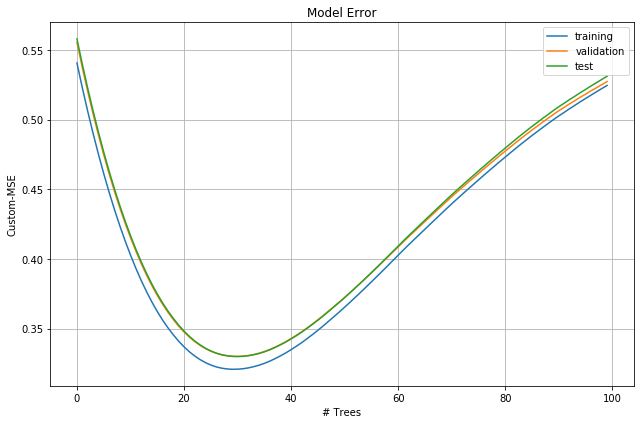

In [21]:
#
# Train the model
#

params = {
#    'objective':'lambdarank', # what to optimize during training
#    'max_position': 10,      # threshold used in optimizing lamdarank (NDCG)
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['None'], #['ndcg'],       # what to use/print for evaluation
#    'ndcg_eval_at': 10
# try printing ndcg and testing
}    

print("training lightgbm...")
start = time.process_time()
lgbm_info = {}
lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = mse_eval,
                            fobj  = mse_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 1)
print("training took " + str(time.process_time() - start) + " s")
print("done")

# Plot the results
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(lgbm_info['train'][METRIC_NAME], label='training')
plt.plot(lgbm_info['valid'][METRIC_NAME], label='validation')
plt.plot(lgbm_info['test'][METRIC_NAME], label='test')
plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel(METRIC_NAME)
plt.title("Model Error")
    